In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from utils.network_analysis import *

import datetime
import os
import string
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gensim
import gensim.models
import nltk
import pickle

from networkx.algorithms import bipartite

In [3]:
# Read network GML objects for house and senate
G_house = nx.read_gml('data/processed/G_house.gml')

In [16]:
edgelist_sentences = [line.split(' ') for line in nx.generate_edgelist(G_house,data=False)]
edgelist_sentences

[['michelebachmann', 'davidlimbaugh'],
 ['michelebachmann', 'redstate'],
 ['michelebachmann', 'heritage'],
 ['michelebachmann', 'scottwalker'],
 ['michelebachmann', 'news_maker'],
 ['michelebachmann', 'allenwest'],
 ['michelebachmann', 'tppatriots'],
 ['michelebachmann', 'foxnewspolitics'],
 ['michelebachmann', 'twitchyteam'],
 ['michelebachmann', 'freedomworks'],
 ['michelebachmann', 'darrellissa'],
 ['michelebachmann', 'cnsnews'],
 ['michelebachmann', 'jennybethm'],
 ['michelebachmann', 'toddcefaratti_'],
 ['michelebachmann', 'tperkins'],
 ['michelebachmann', 'frcdc'],
 ['michelebachmann', 'billyhallowell'],
 ['michelebachmann', 'pjmedia_com'],
 ['michelebachmann', 'edmorrissey'],
 ['michelebachmann', 'pkbird'],
 ['michelebachmann', 'essydh'],
 ['michelebachmann', 'nosflonur'],
 ['michelebachmann', 'bradthevigilant'],
 ['michelebachmann', 'leekatz59'],
 ['michelebachmann', 'sixtylady2'],
 ['michelebachmann', 'nicorc'],
 ['michelebachmann', 'gbozarth'],
 ['michelebachmann', 'netnetske

In [18]:
def ComputeWordEmbeddings(sentences, vector_size=100, min_count=1, workers=8):
    """
    Computes the word embeddings of a list of sentences using the skip-gram Word2Vec algorithm 

    Args:
        - sentences (list(list(str))) : a list of 'sentences', where each sentence is itself a list of strings, representing the sentence in word order
        - vector_size (int) : size of the embedding vector, and embedding space
        - min_count (int) : minimum count of a word in the whole vocabulary needed for it to retained (and not discarded) for model training
        - workers (int) : the number of workers (CPUs) to use during model training.
 
    Returns:
        - word_embeddings_dict (dict) : a dictionary with words (from the sentences) as keys, and values are np.arrays as the embedding for that word
        - model (gensim.models.word2vec.Word2Vec) : Trained Word2Vec model object
    """

    all_words = set([word for sentence in sentences for word in sentence])

    # Train model
    model = gensim.models.Word2Vec(sentences = sentences, sg = 1, vector_size=vector_size, min_count=min_count, workers = 8)

    # Retrieve all words and their embeddings
    word_vectors = model.wv
    words = list(word_vectors.index_to_key)
    word_embeddings = [word_vectors[word] for word in words]
    word_embeddings_dict = dict(zip(words, word_embeddings))

    print(f'{len(all_words)} words loaded. {len(word_embeddings_dict)} words used in training. {vector_size} dimensional vectors produced')

    return word_embeddings_dict, model

In [69]:
embeddings_dct, model = ComputeWordEmbeddings(sentences=edgelist_sentences, vector_size=2, min_count=1, workers=8)

115414 words loaded. 115414 words used in training. 2 dimensional vectors produced


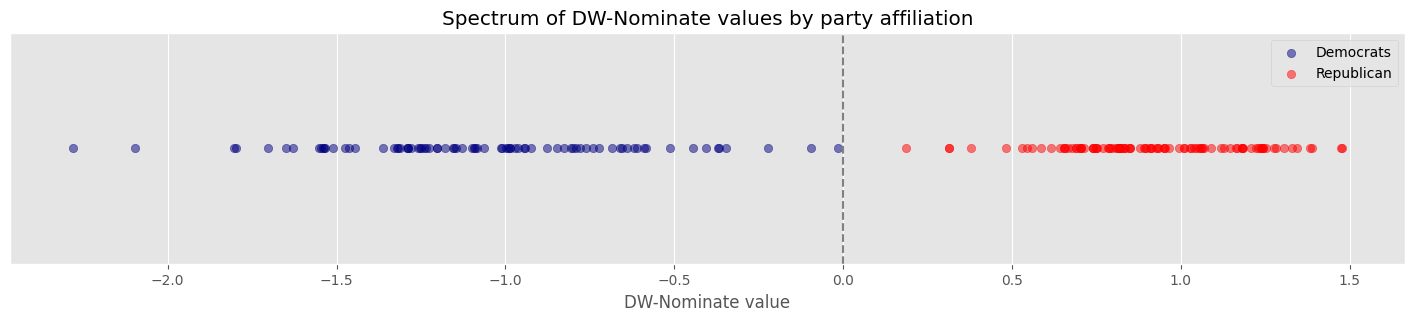

In [74]:
##-- Plot spectrum of DW-Nominate values for each congressperson w/ their party affiliation --##
with plt.style.context("ggplot"):
    plt.figure(figsize=(18, 3))

    democrats = all_members[all_members['party'] == 'D']
    republicans = all_members[all_members['party'] == 'R']

    plt.scatter(democrats['DW-Nominate'], np.zeros(len(democrats)), color='navy', alpha=0.5, label='Democrats')
    plt.scatter(republicans['DW-Nominate'], np.zeros(len(republicans)), color='red', alpha=0.5, label='Republican')
    plt.axvline(x=0, color='grey', linestyle='dashed')
    plt.legend()

    plt.title('Spectrum of DW-Nominate values by party affiliation')
    plt.xlabel('DW-Nominate value')
    plt.yticks([])
    
    plt.show()

In [70]:
G_house.number_of_nodes()

B_nodes, C_nodes = bipartite.sets(G_house)

B_nodes = list(B_nodes)
C_nodes = list(C_nodes)

In [83]:
# Pull list of all 183 congressmembers
congress_members_path = 'data/raw/all_congress_members.csv'
all_members = pd.read_csv(congress_members_path).drop_duplicates('twitter_name')
all_members['congressperson'] = all_members.new_twitter_name.where(all_members.new_twitter_name.notnull(),all_members.twitter_name).str.lower() #Get new/old username as required
all_members['following_count'] = pd.to_numeric(all_members['following_count'], errors='coerce') # Make following count numeric dtype
all_members.head(5)

# Ground truth
democrats = list(all_members[all_members['party'] == 'D']['twitter_name'])
republicans = list(all_members[all_members['party'] == 'R']['twitter_name'])

In [87]:
out = {key : value for key,value in embeddings_dct.items() if key in B_nodes}

democrat_nodes = {key : value for key,value in out.items() if key in democrats}
republican_nodes = {key : value for key,value in out.items() if key in republicans}


democrat_vectors = list(list(i) for i in democrat_nodes.values())
republican_vectors = list(list(i) for i in republican_nodes.values())

x_vals_democrat = [i[0] for i in democrat_vectors]
y_vals_democrat = [i[1] for i in democrat_vectors]

x_vals_republican = [i[0] for i in republican_vectors]
y_vals_republican = [i[1] for i in republican_vectors]

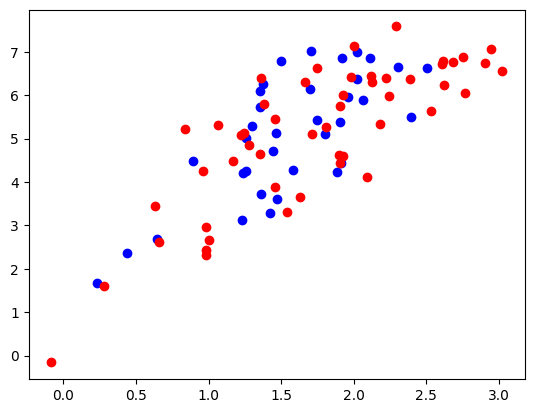

In [91]:
plt.scatter(x_vals_democrat,y_vals_democrat, color='blue')
plt.scatter(x_vals_republican,y_vals_republican, color='red')
plt.show()